## 🎯 Problem: Predict charges (annual medical costs) based on demographics and health-related attributes.

#### ✅ Business Value:

##### Pricing policies correctly.

##### Understanding drivers of cost.

##### Identifying high-risk individuals.

#### ✅ Target Variable:

#####  charges (continuous numeric variable) → regression problem.

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(r"A:\ML Journey\Medical Insurance prediction\insurance.csv")
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


## `We can see the features are mix of both categorical as well as numerical values and target value range is (from ~ 1700 to 22000 in just 5 rows)`

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


### ✅ Observations:

#### No missing values—good!

#### `Data types:`

#### age, bmi, children → numeric.

#### sex, smoker, region → categorical.

#### charges → numeric.

In [8]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


### `✅ Insight:` Likely right-skewed distribution in charges (some people have extremely high costs).

### Steps for now:
> encoding categorical values

> check for outliers

> scaling

> distribution of the target variable

### Step 1: check for the distribution of the target variable

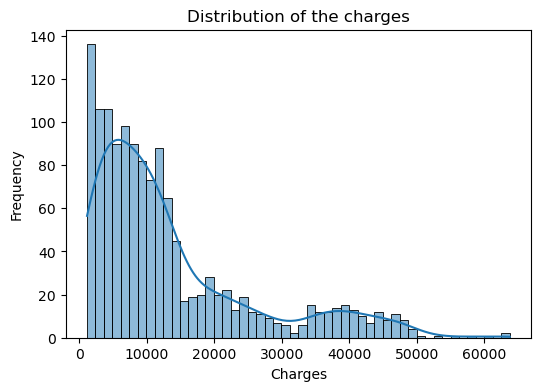

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(df['charges'], bins = 50, kde = True)
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Distribution of the charges')
plt.show()

### `Data is right skewed`
### 📊 What you see
#### Right-skewed distribution.

#### A big spike of people with charges below ~$10,000.

#### A long tail reaching past $60,000.

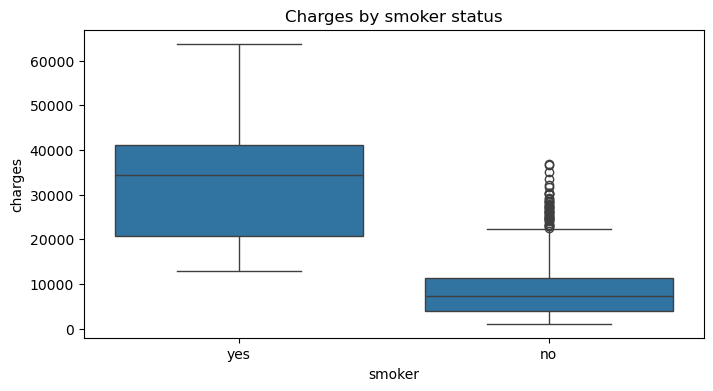

In [14]:
plt.figure(figsize=(8,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by smoker status');

### ` Charges for smoker is high`

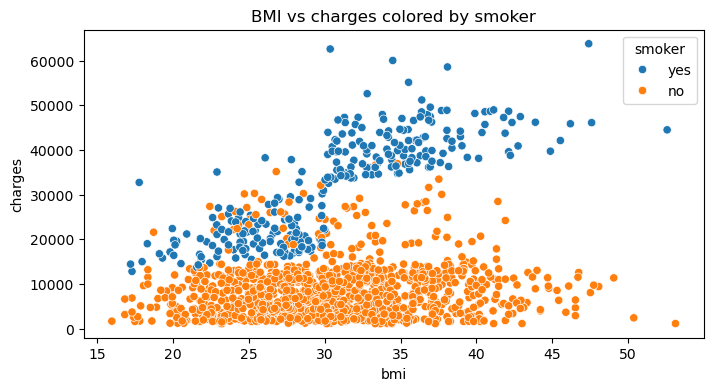

In [16]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x= 'bmi', y= 'charges', data= df, hue='smoker')
plt.title('BMI vs charges colored by smoker');

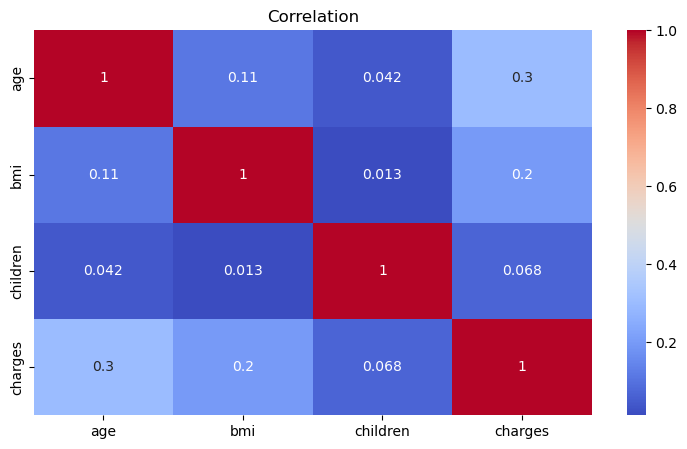

In [17]:
plt.figure(figsize=(9,5))
sns.heatmap(df[['age', 'bmi', 'children', 'charges']].corr(), annot=True, cmap= 'coolwarm')
plt.title('Correlation');

### encode the categorical values

In [19]:
df_encoded = pd.get_dummies(df, drop_first= True).astype(int)

In [20]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,0,1,0,0,1
1,18,33,1,1725,1,0,0,1,0
2,28,33,3,4449,1,0,0,1,0
3,33,22,0,21984,1,0,1,0,0
4,32,28,0,3866,1,0,1,0,0


### train test split

In [22]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop('charges', axis = 1)
y = df_encoded['charges']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

## Fit baseline regression model

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [26]:
print(f"root mean sq error for baseline model : {rmse}")
print(f"r2 score for baseline model : {r2}")

root mean sq error for baseline model : 5793.655127404498
r2 score for baseline model : 0.7837888448800692


## Result for base model is ok now let's improve it

### Check VIF

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()

In [30]:
vif_data = pd.DataFrame()
vif_data['Features'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


           Features        VIF
0               age   7.635389
1               bmi  11.231286
2          children   1.808632
3          sex_male   2.002017
4        smoker_yes   1.260650
5  region_northwest   1.886371
6  region_southeast   2.266486
7  region_southwest   1.959754


### 🧠 VIF Interpretation
#### Recall:

>VIF (Variance Inflation Factor) measures how much a variable’s variance is inflated due to multicollinearity.

>Rules of thumb:

>VIF = 1 → No multicollinearity

>VIF < 5 → Usually acceptable

>VIF 5–10 → Moderate multicollinearity (watch out if interpretation matters)

>VIF >10 → High multicollinearity

## ✅ Industry Practice:

>When the goal is prediction, you don’t always drop high-VIF variables immediately.

>Instead, you often proceed to Ridge/Lasso, which automatically shrink correlated coefficients.

>This is one of the key reasons Ridge was invented:

>To handle multicollinearity without dropping variables.

In [33]:
#scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## Ridge regression

In [35]:
from sklearn.linear_model import Ridge

In [36]:
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train_scale, y_train)

y_pred_ridge = ridge.predict(X_test_scale)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"root mean sq error for ridge is : {rmse_ridge}")
print(f"r2 score for ridge is : {r2_ridge}")

root mean sq error for ridge is : 5794.374868192664
r2 score for ridge is : 0.7837351220920212


In [37]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha= 1.0)

lasso.fit(X_train_scale, y_train)

y_pred_lasso = lasso.predict(X_test_scale)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"root mean sq error for lasso is : {rmse_lasso}")
print(f"r2 score for lasso is : {r2_lasso}")

root mean sq error for lasso is : 5794.024332898622
r2 score for lasso is : 0.7837612875304839


## Decision tree

In [63]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

print(f"root mean sq error for tree is : {rmse_tree}")
print(f"r2 score for tree is : {r2_tree}")

root mean sq error for tree is : 5042.409945417994
r2 score for tree is : 0.8362244303430003


## ✅ Interpretation:

### RMSE dropped substantially (~13% improvement).

### R² jumped from ~0.78 to ~0.83.

>This tells you:

>There are non-linear relationships and interactions (e.g., smoker × BMI × age).

>Linear models simply can’t capture those patterns.

>This is a great sign that ensemble tree methods (Random Forest, Boosting) could push performance even further.

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
rf = RandomForestRegressor(
    n_estimators= 100,
    max_depth=5,
    random_state= 42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"root mean sq error for random forest is : {rmse_rf}")
print(f"r2 score for random forest is : {r2_rf}")

root mean sq error for random forest is : 4498.89262226721
r2 score for random forest is : 0.8696280766129582


## ✅ Interpretation:

### Random Forest improved RMSE by ~22% over linear regression.

>R² is now nearly 0.87, showing the model explains 87% of variance.

### This improvement validates:

>Ensemble methods outperform single trees and linear models.

>Random Forest benefits from averaging multiple diverse trees, reducing variance.

## Gradient Boosting

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

In [79]:
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate= 0.1, 
    max_depth=3,
    random_state= 42
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"root mean sq error for gradient bossting  is : {rmse_gb}")
print(f"r2 score for gradient boosting is : {r2_gb}")

root mean sq error for gradient bossting  is : 4349.155106050793
r2 score for gradient boosting is : 0.8781620424290638


## ✅ Interpretation:

>Gradient Boosting delivered the lowest RMSE and highest R².

>~25% RMSE improvement over linear regression baseline.

>Model explains nearly 88% of variance in charges.

## ✅ Why Gradient Boosting won:

>Trees are built sequentially, each learning to correct prior errors.

>Unlike Random Forest (which builds trees independently), boosting focuses on harder cases.

>This often yields better accuracy (though sometimes at the cost of interpretability).

## Feature importance

In [83]:
feature_importance = pd.Series(
    gb.feature_importances_,
    index = X_train.columns
).sort_values(ascending= False)

print(feature_importance)

smoker_yes          0.684300
bmi                 0.178554
age                 0.120293
children            0.010198
region_northwest    0.003287
region_southwest    0.001528
region_southeast    0.001101
sex_male            0.000739
dtype: float64


## Hypertuning the parameters

In [86]:
from sklearn.model_selection import GridSearchCV

In [94]:
parameter_grid = {
    'n_estimators' : [100,150,200,250,300],
    'learning_rate' : [0.05,0.1,0.15],
    'max_depth' : [3, 4, 5, 6],
    'subsample' : [0.8, 1.0]
}

grid = GridSearchCV(
    estimator= GradientBoostingRegressor(random_state=42),
    param_grid= parameter_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    n_jobs = -1
)

grid.fit(X_train, y_train)

print(f"Best parameters : {grid.best_params_}")

best_gb = grid.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))
r2_best_gb = r2_score(y_test, y_pred_best_gb)

print(f"root mean sq error for best gradient bossting  is : {rmse_best_gb}")
print(f"r2 score for best gradient boosting is : {r2_best_gb}")

Best parameters : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
root mean sq error for best gradient bossting  is : 4381.2539729820355
r2 score for best gradient boosting is : 0.8763569596892891


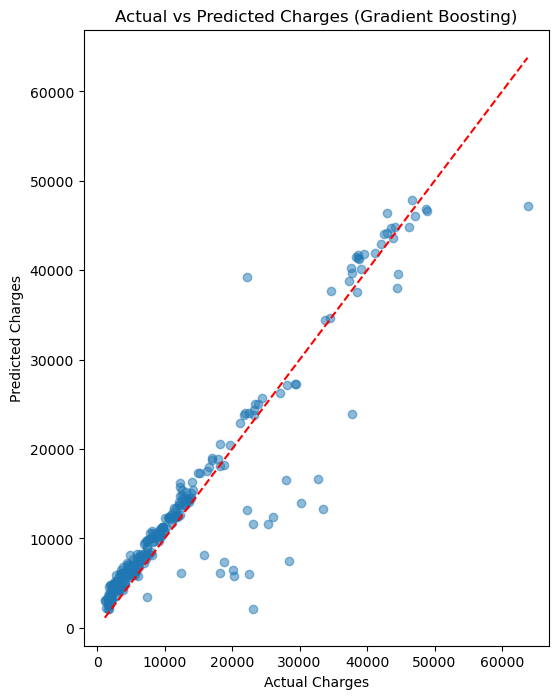

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,8))
plt.scatter(y_test, y_pred_best_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Gradient Boosting)')
plt.show()

## Residual Analysis

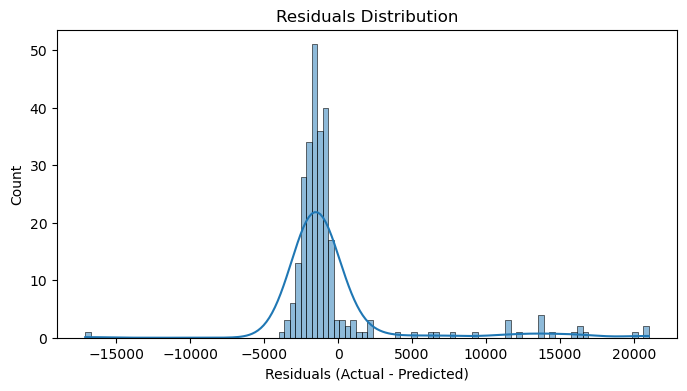

In [99]:
residuals = y_test - y_pred_best_gb

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde= True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.show()